# Default

In [32]:
import os
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, RandomForestRegressor

import tensorflow as tf
import json
from statsmodels.stats.outliers_influence import variance_inflation_factor

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

from statsmodels.graphics.mosaicplot import mosaic
from statistics import stdev

import xgboost as xgb 
import lightgbm as lgb

import itertools

from korean_lunar_calendar import KoreanLunarCalendar
from pycaret.classification import *
from pycaret.regression import *
from time import time

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import *

from bayes_opt import BayesianOptimization
# from hyperopt import fmin, tpe, hp,Trials
from catboost import Pool, CatBoostRegressor

# 폰트 설정 - 윈도우
plt.rcParams['font.family'] = 'NanumGothic'

# 그래프의 크기
plt.rcParams['figure.figsize'] = 12, 6

# 글자 크기
plt.rcParams['font.size'] = 14

# 폰트 설정 시 - 기호 깨는거 방지하기
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

# 절기 구분을 위한 모듈
import datetime
dateformat = '%Y-%m-%d'

# scipy
from scipy.stats import boxcox, yeojohnson
from scipy.special import inv_boxcox

In [33]:
BASE_DIR = './data'

In [34]:
train_path = os.path.join(BASE_DIR, '2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210902_update.xlsx')

data = pd.read_excel(train_path)
data = data[1 : ]
data = data.reset_index(drop = True)
data.iloc[:,6:] = data.iloc[:,6:].apply(pd.to_numeric)  # 수치형으로 변환

data.columns = ['홍수사상번호', '연', '월', '일', '시간', '유입량', 
                '1_유역평균강수', '1_강우(A지역)', '1_강우(B지역)', '1_강우(C지역)', '1_강우(D지역)', '1_수위(E지역)', '1_수위(D지역)', 
                '2_유역평균강수', '2_강우(A지역)', '2_강우(B지역)', '2_강우(C지역)', '2_강우(D지역)', '2_수위(E지역)', '2_수위(D지역)', 
                '3_유역평균강수', '3_강우(A지역)', '3_강우(B지역)', '3_강우(C지역)', '3_강우(D지역)', '3_수위(E지역)', '3_수위(D지역)',
                '4_유역평균강수', '4_강우(A지역)', '4_강우(B지역)', '4_강우(C지역)', '4_강우(D지역)', '4_수위(E지역)', '4_수위(D지역)',
                '5_유역평균강수', '5_강우(A지역)', '5_강우(B지역)', '5_강우(C지역)', '5_강우(D지역)', '5_수위(E지역)', '5_수위(D지역)',
                '6_유역평균강수', '6_강우(A지역)', '6_강우(B지역)', '6_강우(C지역)', '6_강우(D지역)', '6_수위(E지역)', '6_수위(D지역)']

## 기온

In [35]:
weather_path = os.path.join(BASE_DIR, '기상데이터.csv')

weather_data = pd.read_csv(weather_path, encoding = 'euc-kr')
print('기상데이터 적용 전 :', data.shape)
data = pd.merge(data, weather_data,left_index=True, right_index=True, how='left')

print('기상데이터 적용 후 :', data.shape)

기상데이터 적용 전 : (3051, 48)
기상데이터 적용 후 : (3051, 52)


## 음력

In [36]:
solar_date = data[['연', '월', '일']]

# 음력 변환
calendar = KoreanLunarCalendar()

output = []
for i in range(len(solar_date)) :
  year = int(solar_date['연'][i])
  month = int(solar_date['월'][i])
  day = int(solar_date['일'][i])
  calendar.setSolarDate(year, month, day)
  result = calendar.LunarIsoFormat()
  output.append(result)

month = []
day = []
for i in range(len(output)) :
  month.append(output[i].split('-')[1])
  day.append(output[i].split('-')[2].split(' ')[0])

lunar_date = pd.DataFrame([output, month, day]).T
lunar_date.columns = ['음력', '음력_월', '음력_일']

lunar_date['음력_월'] = lunar_date['음력_월'].astype('int')
lunar_date['음력_일'] = lunar_date['음력_일'].astype('int')

In [37]:
data_feat = pd.concat([data, lunar_date], axis = 1)

## 새로운 집단 7 만들어보기

- https://colab.research.google.com/drive/1bsFjsCi-hCGy6uux5ItNhmFZhRfCMQ3b?usp=sharing
- 집단 1 ~ 6까지의 변수들을 각각 최소값과 최대값을 뺀 나머지 4개의 값의 평균으로 집단 7을 만들어보았음

- 수위(E지역)은 모든 집단이 같으므로 안만들었음

In [38]:
data_7 = data_feat[['1_유역평균강수', '2_유역평균강수', '3_유역평균강수', '4_유역평균강수', '5_유역평균강수', '6_유역평균강수']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.DataFrame(lst_mean, columns = ['7_유역평균강수'])

data_7 = data_feat[['1_강우(A지역)', '2_강우(A지역)', '3_강우(A지역)', '4_강우(A지역)', '5_강우(A지역)', '6_강우(A지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(A지역)'])], axis = 1)

data_7 = data_feat[['1_강우(B지역)', '2_강우(B지역)', '3_강우(B지역)', '4_강우(B지역)', '5_강우(B지역)', '6_강우(B지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(B지역)'])], axis = 1)

data_7 = data_feat[['1_강우(C지역)', '2_강우(C지역)', '3_강우(C지역)', '4_강우(C지역)', '5_강우(C지역)', '6_강우(C지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(C지역)'])], axis = 1)

data_7 = data_feat[['1_강우(D지역)', '2_강우(D지역)', '3_강우(D지역)', '4_강우(D지역)', '5_강우(D지역)', '6_강우(D지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(D지역)'])], axis = 1)

data_7 = data_feat[['1_수위(D지역)', '2_수위(D지역)', '3_수위(D지역)', '4_수위(D지역)', '5_수위(D지역)', '6_수위(D지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
    lst.append(list(data_7.loc[i]))
    lst[i].sort()
    lst[i].pop()
    lst[i].sort(reverse = True)
    lst[i].pop()
    lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_수위(D지역)'])], axis = 1)
data_feat = pd.concat([data_feat, data_feat_7], axis = 1)

## rolling

In [39]:
# rolling 1
data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_1'] = data_feat['7_유역평균강수'].shift(1)
data_rolling['7_강우(A지역)_shift_1'] = data_feat['7_강우(A지역)'].shift(1)
data_rolling['7_강우(B지역)_shift_1'] = data_feat['7_강우(B지역)'].shift(1)
data_rolling['7_강우(C지역)_shift_1'] = data_feat['7_강우(C지역)'].shift(1)
data_rolling['7_강우(D지역)_shift_1'] = data_feat['7_강우(D지역)'].shift(1)
data_rolling['7_수위(D지역)_shift_1'] = data_feat['7_수위(D지역)'].shift(1)
data_rolling['7_수위(E지역)_shift_1'] = data_feat['1_수위(E지역)'].shift(1)
for i in range(1, 27) :
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_1'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_1'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_1'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_1'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)

data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [40]:
# rolling 2
data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_2'] = data_feat['7_유역평균강수_shift_1'].shift(1)
data_rolling['7_강우(A지역)_shift_2'] = data_feat['7_강우(A지역)_shift_1'].shift(1)
data_rolling['7_강우(B지역)_shift_2'] = data_feat['7_강우(B지역)_shift_1'].shift(1)
data_rolling['7_강우(C지역)_shift_2'] = data_feat['7_강우(C지역)_shift_1'].shift(1)
data_rolling['7_강우(D지역)_shift_2'] = data_feat['7_강우(D지역)_shift_1'].shift(1)
data_rolling['7_수위(D지역)_shift_2'] = data_feat['7_수위(D지역)_shift_1'].shift(1)
data_rolling['7_수위(E지역)_shift_2'] = data_feat['7_수위(E지역)_shift_1'].shift(1)
for i in range(1, 27) :
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_2'] = dx
        
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_2'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_2'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_2'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_2'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)
data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [41]:
# rolling 3
data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_3'] = data_feat['7_유역평균강수_shift_2'].shift(1)
data_rolling['7_강우(A지역)_shift_3'] = data_feat['7_강우(A지역)_shift_2'].shift(1)
data_rolling['7_강우(B지역)_shift_3'] = data_feat['7_강우(B지역)_shift_2'].shift(1)
data_rolling['7_강우(C지역)_shift_3'] = data_feat['7_강우(C지역)_shift_2'].shift(1)
data_rolling['7_강우(D지역)_shift_3'] = data_feat['7_강우(D지역)_shift_2'].shift(1)
data_rolling['7_수위(D지역)_shift_3'] = data_feat['7_수위(D지역)_shift_2'].shift(1)
data_rolling['7_수위(E지역)_shift_3'] = data_feat['7_수위(E지역)_shift_2'].shift(1)
for i in range(1, 27) :
    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_유역평균강수_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_3'] = dx

    dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(E지역)_shift_3'].iloc[1])
    if dx < 0 :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_3'] = 0
    else :
        data_rolling.loc[lst[i-1], '7_수위(E지역)_shift_3'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)
data_feat = pd.concat([data_feat, data_rolling], axis = 1)

## diff

In [42]:
data_feat['7_유역평균강수_diff'] = pd.DataFrame(data_feat['7_유역평균강수'] - data_feat['7_유역평균강수_shift_1'])
data_feat['7_강우(A지역)_diff'] = pd.DataFrame(data_feat['7_강우(A지역)'] - data_feat['7_강우(A지역)_shift_1'])
data_feat['7_강우(B지역)_diff'] = pd.DataFrame(data_feat['7_강우(B지역)'] - data_feat['7_강우(B지역)_shift_1'])
data_feat['7_강우(C지역)_diff'] = pd.DataFrame(data_feat['7_강우(C지역)'] - data_feat['7_강우(C지역)_shift_1'])
data_feat['7_강우(D지역)_diff'] = pd.DataFrame(data_feat['7_강우(D지역)'] - data_feat['7_강우(D지역)_shift_1'])
data_feat['7_수위(D지역)_diff'] = pd.DataFrame(data_feat['7_수위(D지역)'] - data_feat['7_수위(D지역)_shift_1'])
data_feat['7_수위(E지역)_diff'] = pd.DataFrame(data_feat['1_수위(E지역)'] - data_feat['7_수위(E지역)_shift_1'])

In [43]:
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),일시,기온,풍속,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,7_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,7_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,7_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610,2006-07-10 08:00,24.3,2.0,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600,2006-07-10 09:00,24.6,1.5,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590,2006-07-10 10:00,25.4,1.6,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585,2006-07-10 11:00,25.4,0.9,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575,2006-07-10 12:00,25.3,0.8,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950,2018-07-07 17:00,23

## 홍수기간 칼럼 생성

In [44]:
rain = data_feat.groupby('홍수사상번호')['시간'].count()
lst = np.array(rain.tolist())

flood = []
for i in range(26):
  x = list(range(1, lst[i]+1))
  flood.extend(x)

flood = pd.DataFrame(flood)
flood.columns = ['홍수기간']
data_feat = pd.concat([data_feat, flood], axis = 1)

data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),일시,기온,풍속,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,7_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,7_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,7_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610,2006-07-10 08:00,24.3,2.0,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600,2006-07-10 09:00,24.6,1.5,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590,2006-07-10 10:00,25.4,1.6,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585,2006-07-10 11:00,25.4,0.9,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575,2006-07-10 12:00,25.3,0.8,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950,

## 홍수기간 Binning
- 장마기간의 최댓값 285 & 최솟값 34 사이의 구간을 지정해야 함

In [45]:
bins = [0,30, 50, 70, 100, 120, 160, 220] 
data_feat['홍수_bin'] = np.digitize(data_feat['홍수기간'], bins)
data_feat.groupby('홍수_bin')[['홍수기간']].count()

,홍수기간
홍수_bin,
1,754
2,494
3,416
4,480
5,196
6,263
7,287
8,161


In [46]:
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),일시,기온,풍속,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,7_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,7_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,7_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간,홍수_bin
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610,2006-07-10 08:00,24.3,2.0,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1,1
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600,2006-07-10 09:00,24.6,1.5,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2,1
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590,2006-07-10 10:00,25.4,1.6,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3,1
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585,2006-07-10 11:00,25.4,0.9,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4,1
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575,2006-07-10 12:00,25.3,0.8,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,

## KMEANS

In [47]:
# kmeans를 하기위해서는 변수들이 수치형데이터여야 한다. 그리고 타겟변수인 유입량도 빼준다.
# 그리고 시간의 영향을 제거해보기 위해 시간관련 열들도 제거해본다
data_feat_target = data_feat[data_feat['홍수사상번호'] == 26]
data_feat = data_feat[data_feat['홍수사상번호'] != 26]
data_feat_kmeans = data_feat.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '음력', '음력_월', '음력_일', '유입량'], axis = 1)
data_feat_target_kmeans = data_feat_target.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '음력', '음력_월', '음력_일', '유입량'], axis = 1)

In [48]:
# create model and prediction
scaler = StandardScaler()
model = KMeans(n_clusters=2,algorithm='auto')
pipeline = make_pipeline(scaler,model)
pipeline.fit(data_feat_kmeans)

predict_target = pd.DataFrame(pipeline.predict(data_feat_target_kmeans))
predict_target.columns=['kmeans']
predict = pd.DataFrame(pipeline.predict(data_feat_kmeans))
predict.columns=['kmeans']

In [49]:
# 인덱스 초기화 해서 합쳐주고 다시 원래 인덱스 찾아와야할듯
data_feat = pd.concat([pd.concat([data_feat, predict], axis = 1), pd.concat([data_feat_target.reset_index(), predict_target], axis = 1).set_index('index')])

In [50]:
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),일시,기온,풍속,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,7_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,7_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,7_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간,홍수_bin,kmeans
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610,2006-07-10 08:00,24.3,2.0,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1,1,0
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600,2006-07-10 09:00,24.6,1.5,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2,1,0
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590,2006-07-10 10:00,25.4,1.6,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3,1,0
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585,2006-07-10 11:00,25.4,0.9,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4,1,0
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575,2006-07-10 12:00,25.3,0.8,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0

## 절기

In [51]:
data_time = data_feat[['연', '월', '일', '시간']]

data_time['연'] = [str(int(i)) for i in data_time['연']]
data_time['월'] = [str(int(i)) for i in data_time['월']]
data_time['일'] = [str(int(i)) for i in data_time['일']]
data_time['시간'] = [str(int(i)) for i in data_time['시간']]

In [52]:
# 7월 8일 기준으로 일 차이를 열로 만든다 (소서)
data_time['월일'] = data_time['월'] + '-' + data_time['일']
data_time['월일'] = [datetime.datetime.strptime(i, '%m-%d')  for i in data_time['월일']]
data_time['월일'] = data_time['월일'] - datetime.datetime.strptime('7-8', '%m-%d')
data_time['월일'] = [i.days for i in data_time['월일']]
data_time['절기'] = data_time['월일']
data_time['절기'] = [i // 15 for i in data_time['절기']]

In [53]:
# 6/28 부터 9/24일 까지 시작일 포함 총 89일.
for i in range(len(data_time)) :
  if data_time['절기'].iloc[i] < 0 :
    data_time.loc[i, '절기'] = '하지'
  elif data_time['절기'].iloc[i] == 0 :
    data_time.loc[i, '절기'] = '소서'
  elif data_time['절기'].iloc[i] == 1 :
    data_time.loc[i, '절기'] = '대서'
  elif data_time['절기'].iloc[i] == 2 :
    data_time.loc[i, '절기'] = '입추'
  elif data_time['절기'].iloc[i] == 3 :
    data_time.loc[i, '절기'] = '처서'
  elif data_time['절기'].iloc[i] == 4 :
    data_time.loc[i, '절기'] = '백로'
  else :
    data_time.loc[i, '절기'] = '추분'
    
data_time = data_time[['절기']]
data_feat = pd.concat([data_feat, data_time], axis = 1)

# 변수 적용

In [54]:
py_data = data_feat.copy()
py_data['홍수사상번호'] = py_data['홍수사상번호'].astype('object')
py_data = py_data[py_data['홍수사상번호'] != 1]
py_data = py_data.reset_index(drop = True)
py_data['kmeans'] = py_data['kmeans'].astype('object')
py_data['홍수_bin'] = py_data['홍수_bin'].astype('object')
temp_list = py_data.절기.unique().tolist()
py_data['절기'] = py_data.절기.map(lambda x : temp_list.index(x))
py_data['절기'] = py_data['절기'].astype('object')
py_data = py_data.drop(['일시', '음력', '연', '월', '일', '음력_월', '음력_일', '시간'], axis = 1)

train = py_data[py_data['홍수사상번호'] != 26]
target = py_data[py_data['홍수사상번호'] == 26].reset_index(drop = True)
y_target = py_data[py_data['홍수사상번호'] == 26][['유입량']].reset_index(drop = True)
y_train = py_data[py_data['홍수사상번호'] != 26][['유입량']]

이 위 코드까지 한번에 끌어서 실행하면 됨

In [55]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

cat_columns = [c for c, t in zip(train.dtypes.index, train.dtypes) if t=='O'] 
scale_cols = [c for c in train.drop(['유입량'], axis = 1).columns if c not in cat_columns]

# train 정규화 수행
scaled_df = scaler.fit_transform(train[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
train = train.drop(scaled_df.columns, axis = 1)

scaled_train = pd.concat([train.drop(['유입량'], axis = 1), scaled_df, y_train], axis = 1)


cat_columns = [c for c, t in zip(target.dtypes.index, target.dtypes) if t=='O'] 
scale_cols = [c for c in target.drop(['유입량'], axis = 1).columns if c not in cat_columns]

# target 정규화 수행
scaled_df = scaler.transform(target[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
target = target.drop(scaled_df.columns, axis = 1)

scaled_target = pd.concat([target.drop(['유입량'], axis = 1), scaled_df, y_target], axis = 1)

In [56]:
test_set = scaled_target
train_set = scaled_train
test_set_y = test_set[['유입량']]
train_set_y = train_set[['유입량']]

In [57]:
scaled_train

,홍수사상번호,홍수_bin,kmeans,절기,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),기온,풍속,습도,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,7_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,7_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,7_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,7_수위(E지역)_diff,홍수기간,유입량
0,2.0,1,0,0,-1.211512,-1.063641,-1.053776,-0.899770,-0.923587,-0.654316,0.443851,-1.221509,-1.093210,-1.044989,-0.897534,-0.923587,-0.654316,0.427581,-1.221509,-1.093210,-0.978547,-0.903810,-0.930716,-0.654316,0.419445,-1.221791,-1.108116,-0.978547,-1.022961,-0.954207,-0.654316,0.480296,-1.202271,-1.108116,-0.978547,-1.022961,-0.954207,-0.654316,0.470016,-1.140505,-1.108116,-0.988434,-0.880273,-0.936866,-0.654316,0.458926,-0.219091,-1.185398,0.026468,-1.217243,-1.101129,-1.003651,-0.959067,-0.945329,0.450175,-1.212154,-1.092287,-1.015574,-0.963923,-0.937880,0.458077,-0.635794,-1.202255,-1.083573,-1.008168,-0.956727,-0.930707,0.465875,-0.617286,-1.192507,-1.075002,-1.000576,-0.949557,-0.923659,0.473563,-0.598768,-0.086171,-0.114535,0.135635,0.065317,-0.096329,-0.673435,-0.170684,-1.162192,323.993267
1,2.0,1,0,0,-1.211512,-1.063641,-1.035139,-0.899770,-0.923587,-0.663678,0.440655,-1.211675,-1.093210,-1.026264,-0.897534,-0.923587,-0.663678,0.424739,-1.211675,-1.093210,-0.959173,-0.903810,-0.930716,-0.663678,0.415180,-1.202124,-1.093994,-0.959173,-1.001065,-0.935887,-0.663678,0.477247,-1.182426,-1.093994,-0.959173,-1.001065,-0.935887,-0.663678,0.466603,-1.120061,-1.093994,-0.969160,-0.855459,-0.918191,-0.663678,0.456368,-0.425797,-0.592610,0.199628,-1.202428,-1.094043,-0.984360,-0.947102,-0.936078,0.447171,-1.207215,-1.092287,-0.996262,-0.951961,-0.937880,0.455075,-0.645145,-1.202255,-1.083573,-1.008168,-0.956727,-0.930707,0.462874,-0.626628,-1.192507,-1.075002,-1.000576,-0.949557,-0.923659,0.470564,-0.608106,0.077752,-0.011100,0.135635,0.065317,0.016414,-0.673435,-0.170684,-1.147116,323.154138
2,2.0,1,0,0,-1.201677,-1.063641,-1.035139,-0.899770,-0.923587,-0.668360,0.436392,-1.192009,-1.079002,-1.026264,-0.897534,-0.923587,-0.668360,0.420476,-1.192009,-1.079002,-0.959173,-0.879344,-0.930716,-0.668360,0.410915,-1.180491,-1.079872,-0.959173,-0.979169,-0.917567,-0.668360,0.474197,-1.160596,-1.079872,-0.959173,-0.979169,-0.917567,-0.668360,0.463189,-1.097573,-1.079872,-0.969160,-0.830644,-0.899516,-0.668360,0.452957,-0.391346,-0.948283,0.199628,-1.181688,-1.079873,-0.984360,-0.929155,-0.926827,0.443332,-1.192399,-1.085208,-0.976950,-0.939998,-0.928625,0.452073,-0.654496,-1.197315,-1.083573,-0.988832,-0.944761,-0.930707,0.459873,-0.635971,-1.192507,-1.075002,-1.000576,-0.949557,-0.923659,0.467564,-0.617444,0.176106,0.092335,-0.106149,0.142716,0.016414,-0.742901,-0.125585,-1.132039,293.240313
3,2.0,1,0,0,-1.182007,-1.063641,-1.016501,-0.899770,-0.923587,-0.673041,0.433195,-1.170377,-1.064795,-1.007538,-0.873084,-0.923587,-0.673041,0.416213,-1.170377,-1.064795,-0.939800,-0.854879,-0.912236,-0.673041,0.406650,-1.152957,-1.023383,-0.939800,-0.957274,-0.899247,-0.673041,0.471148,-1.132813,-1.023383,-0.939800,-0.957274,-0.899247,-0.673041,0.459775,-1.068952,-1.023383,-0.949887,-0.805829,-0.880841,-0.673041,0.449547,-0.529150,-1.303956,0.286207,-1.156996,-1.044447,-0.965069,-0.905225,-0.912951,0.439760,-1.171657,-1.071051,-0.976950,-0.922054,-0.919369,0.448235,-0.659

In [58]:
test_set = scaled_target
train_set = scaled_train[scaled_train['홍수사상번호'] != 1].reset_index(drop = True)
test_set_y = test_set[['유입량']]
train_set_y = train_set[['유입량']]

In [59]:
train_set['kmeans'] = train_set['kmeans'].astype('category')
train_set['홍수_bin'] = train_set['홍수_bin'].astype('category')
train_set['절기'] = train_set['절기'].astype('category')

test_set['kmeans'] = test_set['kmeans'].astype('category')
test_set['홍수_bin'] = test_set['홍수_bin'].astype('category')
test_set['절기'] = test_set['절기'].astype('category')

In [60]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   홍수사상번호             2665 non-null   object  
 1   홍수_bin             2665 non-null   category
 2   kmeans             2665 non-null   category
 3   절기                 2665 non-null   category
 4   1_유역평균강수           2665 non-null   float64 
 5   1_강우(A지역)          2665 non-null   float64 
 6   1_강우(B지역)          2665 non-null   float64 
 7   1_강우(C지역)          2665 non-null   float64 
 8   1_강우(D지역)          2665 non-null   float64 
 9   1_수위(E지역)          2665 non-null   float64 
 10  1_수위(D지역)          2665 non-null   float64 
 11  2_유역평균강수           2665 non-null   float64 
 12  2_강우(A지역)          2665 non-null   float64 
 13  2_강우(B지역)          2665 non-null   float64 
 14  2_강우(C지역)          2665 non-null   float64 
 15  2_강우(D지역)          2665 non-null   float64 
 16  2_수위(E

# stacking


In [61]:
def get_predict(train, test, target, n) :    
    model1 = lgb.LGBMRegressor(random_state = 42,
                               n_jobs = -1,
                               feature_fraction = 0.4333407057741526,
                               learning_rate = 0.19063571821788408,
                               max_depth = 6,
                               min_child_weight = 1.7959754525911098,
                               n_estimators = 5780,
                               num_leaves = 131,
                               reg_alpha = 0.05750277604651747,
                               reg_lambda = 0.8575143843171859,
                               subsample = 0.8005575058716043)
    
    model2 = lgb.LGBMRegressor(random_state = 42,
                               n_jobs = -1,
                               boosting_type = 'goss',
                               feature_fraction = 0.7770000834225976,
                               learning_rate = 0.14816927376596317,
                               max_depth = 6,
                               min_child_weight = 0.22634193152740667,
                               n_estimators = 6414,
                               num_leaves = 186,
                               reg_alpha = 0.023192578393987293,
                               reg_lambda = 0.9575539951600276,
                               subsample = 0.6051769440265253)
    
    model3 = xgb.XGBRegressor(random_state = 42,
                              n_jobs = -1,
                              eval_metric = 'rmse',
                              objective='reg:squarederror',
                              colsample_bytree = 0.38637607534866675,
                              gamma = 67.98849651049338,
                              learning_rate = 0.014866598172025397,
                              max_depth = 5,
                              min_child_weight = 1.7224699992946557,
                              n_estimators = 9896,
                              subsample = 0.726566924360085)
    
    model4 = xgb.XGBRegressor(colsample_bytree = 0.99,
                              gamma = 0.0,
                              learning_rate = 0.05,
                              max_depth = 10,
                              min_child_weight = 0.9215786233997231,
                              n_estimators = 6038,
                              reg_alpha = 0.36516267277203135,
                              reg_lambda = 0.01,
                              subsample = 0.7611671326691636)

    data_dbdlq = train[[target]]

    # Train, Valid, Test set 설정
    test_set_y = test[[target]]
    test_set = test.drop([target], axis = 1)

    train_set_y = train[[target]]
    train_set = train.drop([target], axis = 1)
    
    box_result = boxcox(train_set_y[target])
    train_set_y[target] = boxcox(train_set_y[target])[0]

    train_pred = train_set.copy()
    train_pred = train_pred[['홍수사상번호']]
    test_pred = test_set.copy()
    test_pred = test_pred[['홍수사상번호']]
    
    test_result1 = []
    test_result2 = []
    test_result3 = []
    test_result4 = []
    group_kfold = GroupKFold(n_splits = n)
    groups = train_set['홍수사상번호'].values
    group_kfold.get_n_splits(train_set, train_set_y, groups = groups)
    i = 1

    train_set = train_set.drop(['홍수사상번호'], axis = 1)
    test_set = test_set.drop(['홍수사상번호'], axis = 1)

    for train_index, test_index in group_kfold.split(train_set, train_set_y, groups):
        print("{}번째 예측값 생성 {} /".format(i, i), n)
        X_train, X_val = train_set.iloc[train_index], train_set.iloc[test_index]
        y_train, y_val = train_set_y.iloc[train_index], train_set_y.iloc[test_index]

        X_train5 = X_train.copy()
        X_train5['홍수_bin'] = X_train5['홍수_bin'].astype('float')
        X_train5['kmeans'] = X_train5['kmeans'].astype('float')
        X_train5['절기'] = X_train5['절기'].astype('float')
        
        X_val5 = X_val.copy()
        X_val5['홍수_bin'] = X_val5['홍수_bin'].astype('float')
        X_val5['kmeans'] = X_val5['kmeans'].astype('float')
        X_val5['절기'] = X_val5['절기'].astype('float')

        test_set5 = test_set.copy()
        test_set5['홍수_bin'] = test_set5['홍수_bin'].astype('float')
        test_set5['kmeans'] = test_set5['kmeans'].astype('float')
        test_set5['절기'] = test_set5['절기'].astype('float')
        
        model1.fit(X_train, y_train)
        model2.fit(X_train, y_train)
        model3.fit(X_train5, y_train)
        model4.fit(X_train5, y_train)
        
        train_pred.loc[test_index,'model1'] = inv_boxcox(model1.predict(X_val), box_result[1])
        train_pred.loc[test_index,'model2'] = inv_boxcox(model2.predict(X_val), box_result[1])
        train_pred.loc[test_index,'model3'] = inv_boxcox(model3.predict(X_val5), box_result[1])
        train_pred.loc[test_index,'model4'] = inv_boxcox(model4.predict(X_val5), box_result[1])
        
        test_result1.append(inv_boxcox(model1.predict(test_set), box_result[1]))
        test_result2.append(inv_boxcox(model2.predict(test_set), box_result[1]))
        test_result3.append(inv_boxcox(model3.predict(test_set5), box_result[1]))
        test_result4.append(inv_boxcox(model4.predict(test_set5), box_result[1]))
        
        i += 1
    df_test1 = pd.DataFrame(np.mean(pd.DataFrame(test_result1)))
    df_test2 = pd.DataFrame(np.mean(pd.DataFrame(test_result2)))
    df_test3 = pd.DataFrame(np.mean(pd.DataFrame(test_result3)))
    df_test4 = pd.DataFrame(np.mean(pd.DataFrame(test_result4)))

    df_test_con = pd.concat([df_test1, df_test2, df_test3, df_test4], axis = 1).T.reset_index(drop = True).T
    df_test_con.columns = ['model1', 'model2', 'model3', 'model4']
    
    test_pred = test_pred.reset_index(drop = True)
    test_pred = pd.concat([test_pred, df_test_con], axis = 1)
    
    result = pd.concat([train_pred, test_pred], axis = 0).reset_index(drop = True)
    return result

In [62]:
result_ml = get_predict(train_set, test_set, target = '유입량', n = 24) 

1번째 예측값 생성 1 / 24
2번째 예측값 생성 2 / 24
[LightGBM] [Warning] feature_fraction is set=0.4333407057741526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4333407057741526
3번째 예측값 생성 3 / 24
[LightGBM] [Warning] feature_fraction is set=0.4333407057741526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4333407057741526
4번째 예측값 생성 4 / 24
[LightGBM] [Warning] feature_fraction is set=0.4333407057741526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4333407057741526
5번째 예측값 생성 5 / 24
[LightGBM] [Warning] feature_fraction is set=0.4333407057741526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4333407057741526
6번째 예측값 생성 6 / 24
[LightGBM] [Warning] feature_fraction is set=0.4333407057741526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4333407057741526
7번째 예측값 생성 7 / 24
[LightGBM] [Warning] feature_fraction is set=0.4333407057741526, colsample_bytree=1.0 will be ignored. C

In [63]:
data_feat[['유입량']]

,유입량
0,189.100000
1,216.951962
2,251.424419
3,302.812199
4,384.783406
...,...
3046,NaN
3047,NaN
3048,NaN
3049,NaN


In [64]:
result_ml

,홍수사상번호,model1,model2,model3,model4
0,2.0,349.064253,333.939611,381.935699,361.769623
1,2.0,329.206681,285.343993,367.677429,333.013641
2,2.0,284.843311,295.188698,360.956207,304.555542
3,2.0,265.245707,316.595854,362.120789,295.848846
4,2.0,282.592142,286.250537,362.120789,284.374878
...,...,...,...,...,...
2820,26.0,461.863154,414.814202,529.531250,434.970539
2821,26.0,436.761321,392.615989,493.644805,416.457108
2822,26.0,428.902660,390.509413,482.827283,404.845469
2823,26.0,421.588864,400.320463,473.963669,408.978546


In [65]:
# train_set, test_set
# sequence dataset 만드는 함수 설정
def make_sequene_dataset(feature, label, window_size):
    
    feature_list = []
    label_list = []
    
    for i in range(len(feature)-window_size):
        # feature[i:i+window_size] 슬라이싱을 이용하여 
        # [[...], [...], ..] 형상으로 입력데이터, 즉 feature 생성
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

def rmse(y_pred, y_true):
    RMSE = mean_squared_error(y_true, y_pred)**0.5
    return RMSE

def train_val_test(train, test, target, n) :    
    
    train['홍수_bin'] = train['홍수_bin'].astype('float')
    train['kmeans'] = train['kmeans'].astype('float')
    train['절기'] = train['절기'].astype('float')
    
    test['홍수_bin'] = test['홍수_bin'].astype('float')
    test['kmeans'] = test['kmeans'].astype('float')
    test['절기'] = test['절기'].astype('float')

    # Train, Test set 설정
    test_set_y = test[[target]]
    test_set = test.drop([target], axis = 1)

    train_set_y = train[[target]]
    train_set = train.drop([target], axis = 1)
    
    box_result = boxcox(train_set_y[target])
    train_set_y[target] = boxcox(train_set_y[target])[0]

    train_pred = train_set.copy()
    train_pred = train_pred[['홍수사상번호']]
    test_pred = test_set.copy()
    test_pred = test_pred[['홍수사상번호']]
    
    
    result = []
    result_rmse = []
    
    # 사상별로 검증을 수행하기 위해 group K fold 수행
    group_kfold = GroupKFold(n_splits = n)
    groups = train_set['홍수사상번호'].values
    group_kfold.get_n_splits(train_set, train_set_y, groups = groups)
    i = 1

    train_set = train_set.drop(['홍수사상번호'], axis = 1)
    test_set = test_set.drop(['홍수사상번호'], axis = 1)
    
    # test 사상을 제외시킨 뒤, 남은 데이터로 교차검증 수행
    for train_index, test_index in group_kfold.split(train_set, train_set_y, groups):
        print("{}번째 교차검증 {} /".format(i, i), n)
        X_train, X_val = train_set.iloc[train_index], train_set.iloc[test_index]
        y_train, y_val = train_set_y.iloc[train_index], train_set_y.iloc[test_index] 

        # 딥러닝 학습을 위해 numpy로 변환
        label_np = y_train.to_numpy()
        feature_np = X_train.to_numpy()

        label_valid_np = y_val.to_numpy()
        feature_valid_np = X_val.to_numpy()

        label_test_np = test_set_y.to_numpy()
        feature_test_np = test_set.to_numpy()
        
        # window_size = 
        window_size = 5
        x_train, y_train = make_sequene_dataset(feature_np, label_np, window_size)
        x_valid, y_valid = make_sequene_dataset(feature_valid_np, label_valid_np, window_size)
        x_test, y_test = make_sequene_dataset(feature_test_np, label_test_np, window_size)
        
        # LSTM  모델 구축
        
        model = Sequential()
        model.add(LSTM(526, activation = 'tanh', 
                       input_shape = x_train[0].shape))

        model.add(Dense(256))
        model.add(Dense(1, activation='linear'))


        model.summary()

        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        early_stop = EarlyStopping(monitor = 'mae', patience = 5)
        model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, verbose=0,
                  batch_size = 200, callbacks = [early_stop])


        pred = inv_boxcox(model.predict(x_valid), box_result[1])
        train_pred.loc[test_index[5:],'lstm'] = pred

        i += 1
    
    label_np = train_set_y.to_numpy()
    feature_np = train_set.to_numpy()
    label_test_np = test_set_y.to_numpy()
    feature_test_np = test_set.to_numpy()

    window_size = 5
    x_train, y_train = make_sequene_dataset(feature_np, label_np, window_size)
    x_test, y_test = make_sequene_dataset(feature_test_np, label_test_np, window_size)    
    
    # LSTM  모델 구축
    model = Sequential()
    # LSTM 신경망
    model.add(LSTM(526, activation = 'tanh', 
                   input_shape = x_train[0].shape))
    model.add(Dense(256))
    # Linear로 활성화함수를 한 이유는 ReLU로 설정했을 때, 신경망이 죽는 현상 발생
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stop = EarlyStopping(monitor = 'mae', patience = 5)
    model.fit(x_train, y_train, epochs = 1000, verbose=0,
              batch_size = 200, callbacks = [early_stop])
    pred = inv_boxcox(model.predict(x_test), box_result[1])
    test_pred.loc[5 : ,'lstm'] = pred   
    
    result_lstm = pd.concat([train_pred, test_pred], axis = 0).reset_index(drop = True)
    return result_lstm

result_lstm = train_val_test(train_set, test_set, target = '유입량', n = 24) 

1번째 교차검증 1 / 24
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 526)               1283440   
_________________________________________________________________
dense (Dense)                (None, 256)               134912    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,418,609
Trainable params: 1,418,609
Non-trainable params: 0
_________________________________________________________________
2번째 교차검증 2 / 24
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 526)               1283440   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               134

12번째 교차검증 12 / 24
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 526)               1283440   
_________________________________________________________________
dense_22 (Dense)             (None, 256)               134912    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 1,418,609
Trainable params: 1,418,609
Non-trainable params: 0
_________________________________________________________________
13번째 교차검증 13 / 24
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 526)               1283440   
_________________________________________________________________
dense_24 (Dense)             (None, 256)          

21번째 교차검증 21 / 24
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 526)               1283440   
_________________________________________________________________
dense_40 (Dense)             (None, 256)               134912    
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 257       
Total params: 1,418,609
Trainable params: 1,418,609
Non-trainable params: 0
_________________________________________________________________
22번째 교차검증 22 / 24
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 526)               1283440   
_________________________________________________________________
dense_42 (Dense)             (None, 256)          

In [66]:
pred_result = pd.concat([result_ml.drop(['홍수사상번호'], axis = 1), result_lstm[['lstm']]], axis = 1)
pred_result = pred_result.T.fillna(pred_result.T.mean()).T
pred_result.columns = ['lgbm_gbdt', 'lgbm_goss', 'xgb', 'xgb2', 'lstm']

In [67]:
data_feat['True'] = data_feat['유입량']
data_true = data_feat.copy()
data_true = data_true[data_true['홍수사상번호'] != 1].reset_index(drop = True)

## 예측값과 실제값 비교

Text(0.5, 1.0, 'Flood 25 : LSTM')

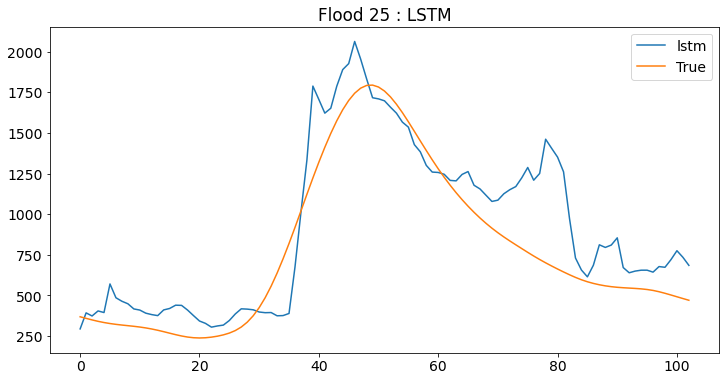

In [92]:
pd.concat([pred_result[pred_result['홍수사상번호'] == 25]['lstm'].reset_index(drop = True), data_true[data_true['홍수사상번호'] == 25][['True']].reset_index(drop = True)], axis = 1).plot()
plt.title('Flood 25 : LSTM')

<AxesSubplot:>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


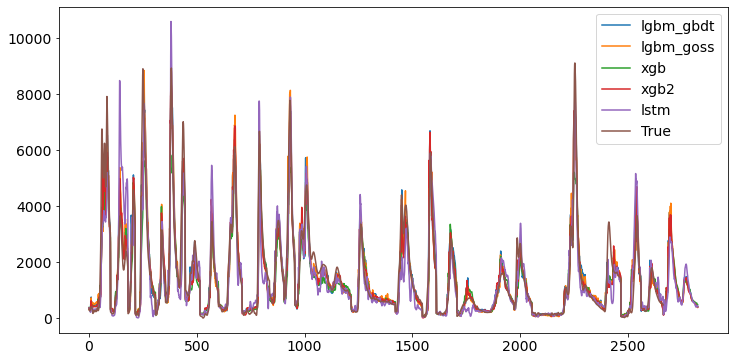

In [68]:
pd.concat([pred_result, data_true[['True']]], axis = 1).plot()

<AxesSubplot:>

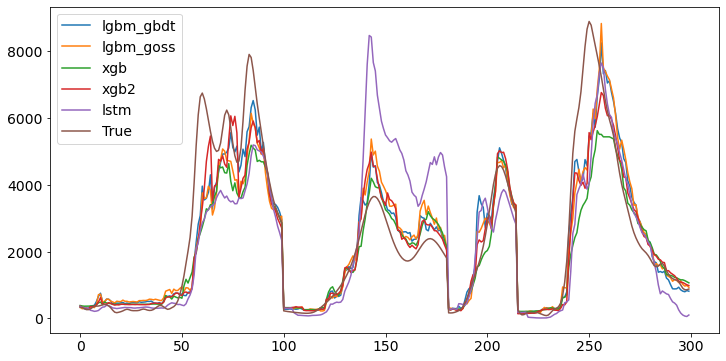

In [69]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[ : 300].plot()

<AxesSubplot:>

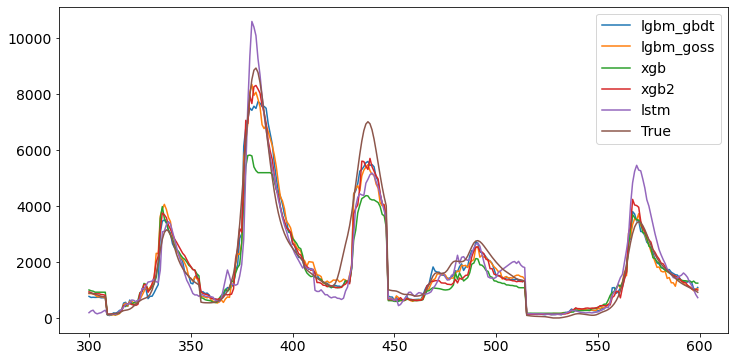

In [70]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[300:600].plot()

<AxesSubplot:>

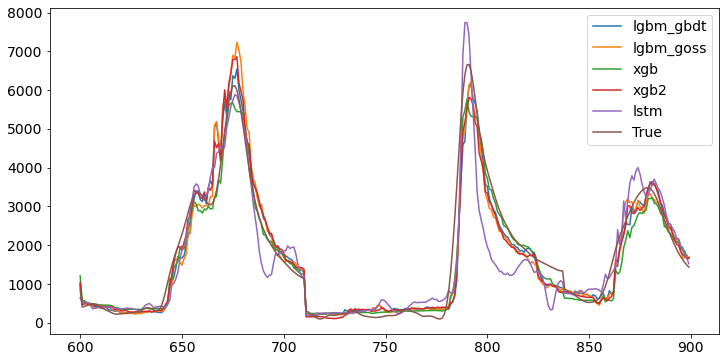

In [71]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[600:900].plot()

<AxesSubplot:>

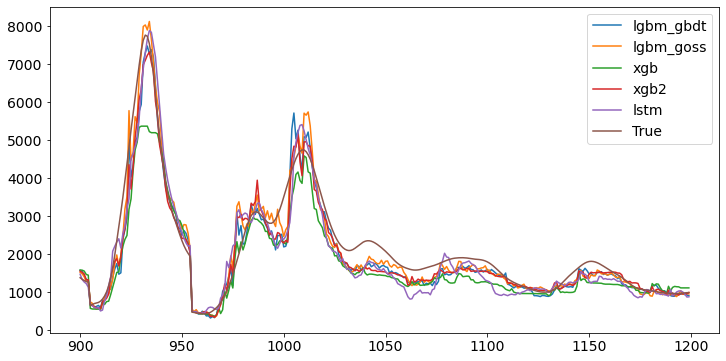

In [72]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[900:1200].plot()

<AxesSubplot:>

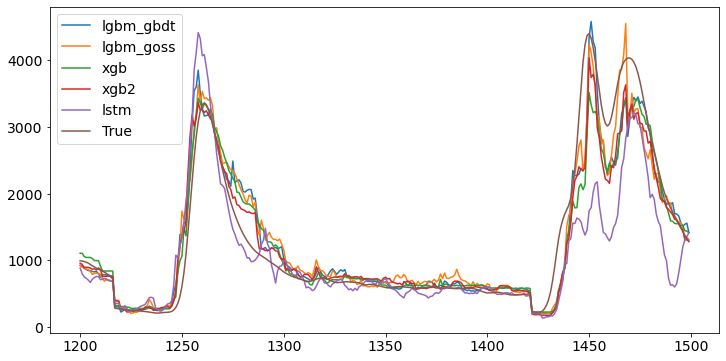

In [73]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[1200:1500].plot()

<AxesSubplot:>

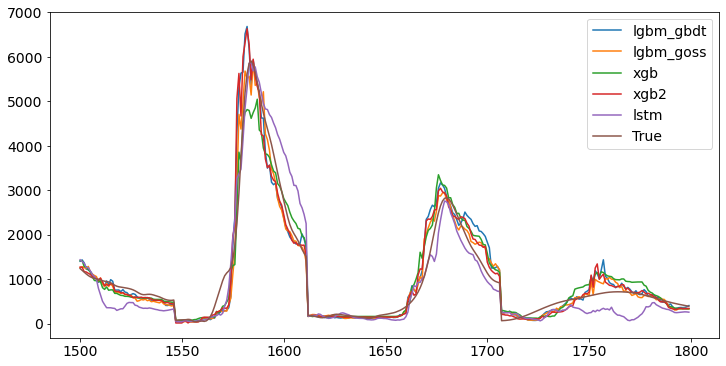

In [74]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[1500:1800].plot()

<AxesSubplot:>

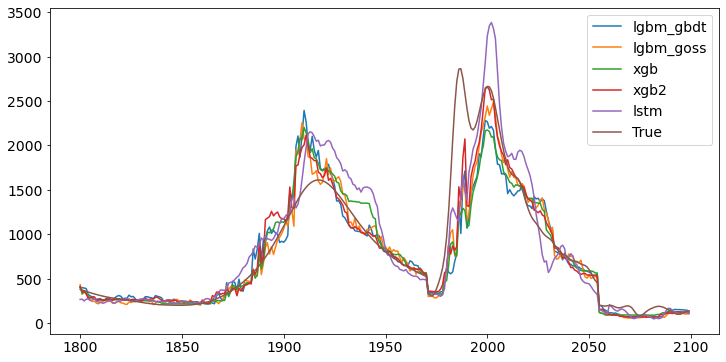

In [75]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[1800:2100].plot()

<AxesSubplot:>

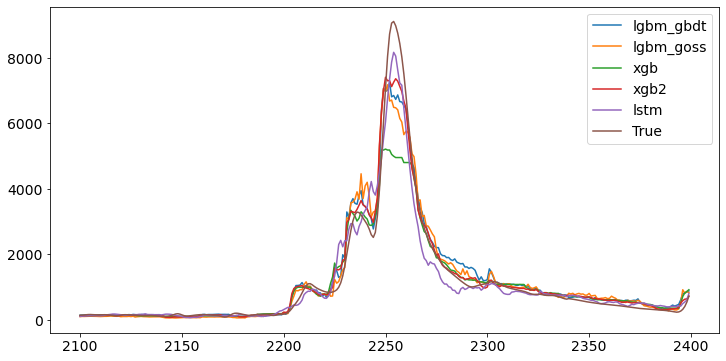

In [76]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[2100:2400].plot()

<AxesSubplot:>

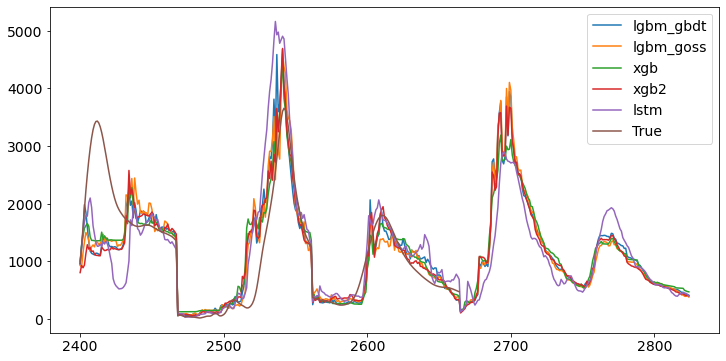

In [77]:
pd.concat([pred_result, data_true[['True']]], axis = 1).iloc[2400:].plot()

Text(0.5, 1.0, 'Flood 25')

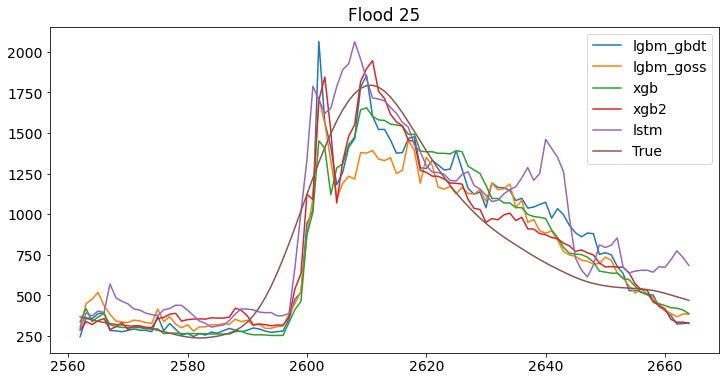

In [95]:
pd.concat([pred_result[pred_result['홍수사상번호'] == 25].drop(['홍수사상번호'], axis = 1), data_true[data_true['홍수사상번호'] == 25][['True']]], axis = 1).plot()
plt.title('Flood 25')

In [78]:
pred_result = pd.concat([data_true[['홍수사상번호']], pred_result], axis = 1)
print("LightGBM_gbdt's RMSE", np.sqrt(mean_squared_error(pred_result[pred_result['홍수사상번호'] == 25]['lgbm_gbdt'], data_true[data_true['홍수사상번호'] == 25]['유입량'])))
print("LightGBM_goss's RMSE", np.sqrt(mean_squared_error(pred_result[pred_result['홍수사상번호'] == 25]['lgbm_goss'], data_true[data_true['홍수사상번호'] == 25]['유입량'])))
print("XGBoost1's RMSE", np.sqrt(mean_squared_error(pred_result[pred_result['홍수사상번호'] == 25]['xgb'], data_true[data_true['홍수사상번호'] == 25]['유입량'])))
print("XGBoost2's RMSE", np.sqrt(mean_squared_error(pred_result[pred_result['홍수사상번호'] == 25]['xgb2'], data_true[data_true['홍수사상번호'] == 25]['유입량'])))
print("LSTM's RMSE", np.sqrt(mean_squared_error(pred_result[pred_result['홍수사상번호'] == 25]['lstm'], data_true[data_true['홍수사상번호'] == 25]['유입량'])))

LightGBM_gbdt's RMSE 217.35514131889133
LightGBM_goss's RMSE 218.16476291704902
XGBoost1's RMSE 184.5382661733479
XGBoost2's RMSE 161.38768365374958
LSTM's RMSE 242.26444633095971


In [79]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

print("LightGBM_gbdt's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] != 26]['lgbm_gbdt'], data_true[data_true['홍수사상번호'] != 26]['유입량']))
print("LightGBM_goss's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] != 26]['lgbm_goss'], data_true[data_true['홍수사상번호'] != 26]['유입량']))
print("XGBoost1's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] != 26]['xgb'], data_true[data_true['홍수사상번호'] != 26]['유입량']))
print("XGBoost2's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] != 26]['xgb2'], data_true[data_true['홍수사상번호'] != 26]['유입량']))
print("LSTM's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] != 26]['lstm'], data_true[data_true['홍수사상번호'] != 26]['유입량']))

LightGBM_gbdt's MAPE 25.770023072086385
LightGBM_goss's MAPE 27.817488688863474
XGBoost1's MAPE 26.54971308195882
XGBoost2's MAPE 25.9368008001912
LSTM's MAPE 46.031261075789985


In [82]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

print("LightGBM_gbdt's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] == 25]['lgbm_gbdt'], data_true[data_true['홍수사상번호'] == 25]['유입량']))
print("LightGBM_goss's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] == 25]['lgbm_goss'], data_true[data_true['홍수사상번호'] == 25]['유입량']))
print("XGBoost1's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] == 25]['xgb'], data_true[data_true['홍수사상번호'] == 25]['유입량']))
print("XGBoost2's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] == 25]['xgb2'], data_true[data_true['홍수사상번호'] == 25]['유입량']))
print("LSTM's MAPE", MAPE(pred_result[pred_result['홍수사상번호'] == 25]['lstm'], data_true[data_true['홍수사상번호'] == 25]['유입량']))

LightGBM_gbdt's MAPE 24.055738613899752
LightGBM_goss's MAPE 24.412296260669038
XGBoost1's MAPE 21.68791604433479
XGBoost2's MAPE 20.843314967321362
LSTM's MAPE 23.50815948590447


In [80]:
train_stack = pred_result[pred_result['홍수사상번호'] != 26]
train_stack = train_stack[train_stack['홍수사상번호'] != 25]

model = xgb.XGBRegressor(random_state = 42)
model.fit(train_stack.drop(['홍수사상번호'], axis = 1), data_true[~data_true['홍수사상번호'].isin([25, 26])][['유입량']])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

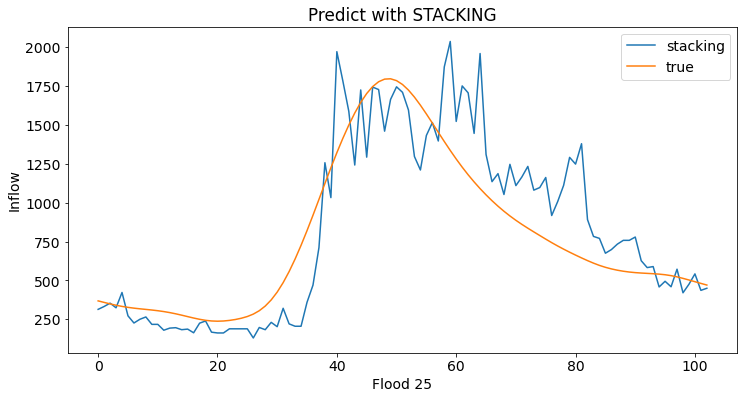

STACKING RMSE : 273.28146187619603
STACKING MAPE : 33.98212370603585


In [87]:
y_pred = model.predict(pred_result[pred_result['홍수사상번호'] == 25].drop(['홍수사상번호'], axis = 1))  
stack_result = pd.DataFrame(y_pred, columns = ['stacking'])
stack_result['true'] = data_true[data_true['홍수사상번호'] == 25][['유입량']].reset_index(drop = True)
stack_result.plot()
plt.title('Predict with STACKING')
plt.xlabel('Flood 25')
plt.ylabel('Inflow')
plt.legend()
plt.show()


print('STACKING RMSE :', np.sqrt(mean_squared_error( y_pred,  data_true[data_true['홍수사상번호'] == 25][['유입량']] )))
print('STACKING MAPE :', MAPE( y_pred,  data_true[data_true['홍수사상번호'] == 25]['유입량'] ))